## 1. Import Libraries

In [50]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)
from feature_engine.datetime import DatetimeFeatures

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [2]:
pd.set_option("display.max_columns", None)

In [3]:
sklearn.set_config(transform_output="pandas")

In [4]:
warnings.filterwarnings("ignore")

## 3. Read the Data

In [5]:
path = r"E:\Flight_Price_sagemaker\Data\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-06,Kolkata,Banglore,08:25:00,18:15:00,590,1.0,In-flight meal not included,10844
1,Air India,2019-03-01,Banglore,New Delhi,05:50:00,08:50:00,1620,3.0,No Info,13081
2,Indigo,2019-03-06,Delhi,Cochin,18:35:00,01:35:00,420,1.0,No Info,14871
3,Air India,2019-03-24,Kolkata,Banglore,07:00:00,10:00:00,1620,2.0,No Info,11491
4,Air India,2019-04-06,Kolkata,Banglore,20:45:00,23:20:00,155,0.0,No Info,4460
...,...,...,...,...,...,...,...,...,...,...
635,Indigo,2019-03-09,Chennai,Kolkata,05:15:00,07:35:00,140,0.0,No Info,6482
636,Spicejet,2019-05-24,Chennai,Kolkata,17:45:00,20:05:00,140,0.0,No Info,3597
637,Indigo,2019-06-12,Mumbai,Hyderabad,01:40:00,03:10:00,90,0.0,No Info,2754
638,Spicejet,2019-05-15,Kolkata,Banglore,06:55:00,09:30:00,155,0.0,No check-in baggage included,3841


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      639 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [7]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

#### 4.1 airline

In [8]:
X_train.airline

0      Jet Airways
1        Air India
2           Indigo
3        Air India
4        Air India
          ...     
635         Indigo
636       Spicejet
637         Indigo
638       Spicejet
639    Jet Airways
Name: airline, Length: 640, dtype: object

In [9]:
air_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
    # ("encoder", OneHotEncoder(sparse_output=False, handle_unknown = "ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])

,airline
0,Jet Airways
1,Air India
2,Indigo
3,Air India
4,Air India
...,...
635,Indigo
636,Other
637,Indigo
638,Other


### 4.2 date_of_journey

In [10]:
X_train.date_of_journey

0      2019-05-06
1      2019-03-01
2      2019-03-06
3      2019-03-24
4      2019-04-06
          ...    
635    2019-03-09
636    2019-05-24
637    2019-06-12
638    2019-05-15
639    2019-05-12
Name: date_of_journey, Length: 640, dtype: object

In [11]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
    ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.588235,0.000000,0.559322
1,0.000000,0.000000,0.666667,0.000000
2,0.000000,0.058824,0.333333,0.042373
3,0.000000,0.176471,1.000000,0.194915
4,0.333333,0.294118,0.833333,0.305085
...,...,...,...,...
635,0.000000,0.058824,0.833333,0.067797
636,0.666667,0.705882,0.666667,0.711864
637,1.000000,0.882353,0.333333,0.872881
638,0.666667,0.647059,0.333333,0.635593


### 4.3 source & destination

In [12]:
X_train.source

0       Kolkata
1      Banglore
2         Delhi
3       Kolkata
4       Kolkata
         ...   
635     Chennai
636     Chennai
637      Mumbai
638     Kolkata
639     Kolkata
Name: source, Length: 640, dtype: object

In [13]:
X_train.destination

0       Banglore
1      New Delhi
2         Cochin
3       Banglore
4       Banglore
         ...    
635      Kolkata
636      Kolkata
637    Hyderabad
638     Banglore
639     Banglore
Name: destination, Length: 640, dtype: object

In [14]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Kolkata,Banglore
1,Banglore,New Delhi
2,Delhi,Cochin
3,Kolkata,Banglore
4,Kolkata,Banglore
...,...,...
635,Chennai,Kolkata
636,Chennai,Kolkata
637,Mumbai,Hyderabad
638,Kolkata,Banglore


In [15]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol = 0.1, replace_with = "Other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,0.141206,0.137044
1,-1.076005,-0.999533
2,1.022268,1.022226
3,0.141206,0.137044
4,0.141206,0.137044
...,...,...
635,-1.769492,-0.999533
636,-1.769492,-0.999533
637,-1.769492,-0.999533
638,0.141206,0.137044


In [16]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [17]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return(
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)


,source_is_north,destination_is_north
0,1,0
1,0,1
2,1,0
3,1,0
4,1,0
...,...,...
635,0,1
636,0,1
637,1,0
638,1,0


In [18]:
location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,0.141206,0.137044,1,0
1,-1.076005,-0.999533,0,1
2,1.022268,1.022226,1,0
3,0.141206,0.137044,1,0
4,0.141206,0.137044,1,0
...,...,...,...,...
635,-1.769492,-0.999533,0,1
636,-1.769492,-0.999533,0,1
637,-1.769492,-0.999533,1,0
638,0.141206,0.137044,1,0


### 4.4 dep_time & arrival_time

In [19]:
X_train.dep_time

0      08:25:00
1      05:50:00
2      18:35:00
3      07:00:00
4      20:45:00
         ...   
635    05:15:00
636    17:45:00
637    01:40:00
638    06:55:00
639    20:00:00
Name: dep_time, Length: 640, dtype: object

In [20]:
X_train.arrival_time

0      18:15:00
1      08:50:00
2      01:35:00
3      10:00:00
4      23:20:00
         ...   
635    07:35:00
636    20:05:00
637    03:10:00
638    09:30:00
639    09:20:00
Name: arrival_time, Length: 640, dtype: object

In [21]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,08:25:00,18:15:00
1,05:50:00,08:50:00
2,18:35:00,01:35:00
3,07:00:00,10:00:00
4,20:45:00,23:20:00
...,...,...
635,05:15:00,07:35:00
636,17:45:00,20:05:00
637,01:40:00,03:10:00
638,06:55:00,09:30:00


In [22]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.347826,0.454545,0.782609,0.272727
1,0.217391,0.909091,0.347826,0.909091
2,0.782609,0.636364,0.043478,0.636364
3,0.304348,0.000000,0.434783,0.000000
4,0.869565,0.818182,1.000000,0.363636
...,...,...,...,...
635,0.217391,0.272727,0.304348,0.636364
636,0.739130,0.818182,0.869565,0.090909
637,0.043478,0.727273,0.130435,0.181818
638,0.260870,1.000000,0.391304,0.545455


In [23]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns=X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })

    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"),
                 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                 X_temp.loc[:, col].between(eve, night,  inclusive="left")],
                ["morning", "afternoon", "evening"],
                default="night"
            )
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,evening
1,morning,morning
2,evening,night
3,morning,morning
4,night,night
...,...,...
635,morning,morning
636,evening,night
637,night,night
638,morning,morning


In [24]:
time_pipe2 = Pipeline(steps = [
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()),
    ("scale", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.591398
1,1.000000,0.860215
2,0.187192,1.000000
3,1.000000,0.860215
4,0.113300,1.000000
...,...,...
635,1.000000,0.860215
636,0.187192,1.000000
637,0.113300,1.000000
638,1.000000,0.860215


In [25]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.347826,0.454545,0.782609,0.272727,1.000000,0.591398
1,0.217391,0.909091,0.347826,0.909091,1.000000,0.860215
2,0.782609,0.636364,0.043478,0.636364,0.187192,1.000000
3,0.304348,0.000000,0.434783,0.000000,1.000000,0.860215
4,0.869565,0.818182,1.000000,0.363636,0.113300,1.000000
...,...,...,...,...,...,...
635,0.217391,0.272727,0.304348,0.636364,1.000000,0.860215
636,0.739130,0.818182,0.869565,0.090909,0.187192,1.000000
637,0.043478,0.727273,0.130435,0.181818,0.113300,1.000000
638,0.260870,1.000000,0.391304,0.545455,1.000000,0.860215


### 4.5 duration

In [26]:
X_train.duration

0       590
1      1620
2       420
3      1620
4       155
       ... 
635     140
636     140
637      90
638     155
639     800
Name: duration, Length: 640, dtype: int64

In [27]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])
    .values
    .reshape(-1, 1)
    # .shape
)

array([[170.  ],
       [450.  ],
       [916.25]])

In [28]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include = "number").columns.to_list()

        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }

        return self

    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
            obj = pd.DataFrame(
                data = rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma = self.gamma),
                columns = columns
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)



In [29]:
# RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

In [ ]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [ ]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [30]:
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),
    ("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])


duration_union = FeatureUnion(transformer_list = [
    ("part1", duration_pipe1),
    ("part2", duration_pipe2),
    ("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
    ("imputer", SimpleImputer(strategy="median")),
    ("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration
0,-0.410157,-0.113704,-0.119302,-0.043229
1,-0.410157,-0.113704,-0.119302,2.008828
2,-0.410157,-0.113704,-0.119302,-0.381918
3,-0.410157,-0.113704,-0.119302,2.008828
4,-0.410157,-0.113704,-0.119302,-0.909874
...,...,...,...,...
635,-0.410157,-0.113704,-0.119302,-0.939759
636,-0.410157,-0.113704,-0.119302,-0.939759
637,-0.410157,-0.113704,-0.119302,-1.039373
638,-0.410157,-0.113704,-0.119302,-0.909874


### 4.6 total_stops

In [31]:
X_train.total_stops

0      1.0
1      3.0
2      1.0
3      2.0
4      0.0
      ... 
635    0.0
636    0.0
637    0.0
638    0.0
639    1.0
Name: total_stops, Length: 640, dtype: float64

In [34]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,3.0,0
2,1.0,0
3,2.0,0
4,0.0,1
...,...,...
635,0.0,1
636,0.0,1
637,0.0,1
638,0.0,1


### 4.7 additional_info

In [35]:
X_train.additional_info

0       In-flight meal not included
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
635                         No Info
636                         No Info
637                         No Info
638    No check-in baggage included
639                         No Info
Name: additional_info, Length: 640, dtype: object

In [36]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output = False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,0.0,1.0,0.0
638,0.0,0.0,1.0


In [37]:
def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [38]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [39]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,1.0,0.0,0.0,1
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,0.0,1.0,0.0,0
638,0.0,0.0,1.0,1


## 5. Column Transformer

In [40]:
column_transformer = ColumnTransformer(transformers=[
    ("air", air_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]),
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,Jet Airways,0.666667,0.588235,0.000000,0.559322,0.141206,0.137044,1,0,0.347826,0.454545,0.782609,0.272727,1.000000,0.591398,-0.410157,-0.113704,-0.119302,-0.043229,1.0,0,1.0,0.0,0.0,1
1,Air India,0.000000,0.000000,0.666667,0.000000,-1.076005,-0.999533,0,1,0.217391,0.909091,0.347826,0.909091,1.000000,0.860215,-0.410157,-0.113704,-0.119302,2.008828,3.0,0,0.0,1.0,0.0,0
2,Indigo,0.000000,0.058824,0.333333,0.042373,1.022268,1.022226,1,0,0.782609,0.636364,0.043478,0.636364,0.187192,1.000000,-0.410157,-0.113704,-0.119302,-0.381918,1.0,0,0.0,1.0,0.0,0
3,Air India,0.000000,0.176471,1.000000,0.194915,0.141206,0.137044,1,0,0.304348,0.000000,0.434783,0.000000,1.000000,0.860215,-0.410157,-0.113704,-0.119302,2.008828,2.0,0,0.0,1.0,0.0,0
4,Air India,0.333333,0.294118,0.833333,0.305085,0.141206,0.137044,1,0,0.869565,0.818182,1.000000,0.363636,0.113300,1.000000,-0.410157,-0.113704,-0.119302,-0.909874,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,Indigo,0.000000,0.058824,0.833333,0.067797,-1.769492,-0.999533,0,1,0.217391,0.272727,0.304348,0.636364,1.000000,0.860215,-0.410157,-0.113704,-0.119302,-0.939759,0.0,1,0.0,1.0,0.0,0
636,Other,0.666667,0.705882,0.666667,0.711864,-1.769492,-0.999533,0,1,0.739130,0.818182,0.869565,0.090909,0.187192,1.000000,-0.410157,-0.113704,-0.119302,-0.939759,0.0,1,0.0,1.0,0.0,0
637,Indigo,1.000000,0.882353,0.333333,0.872881,-1.769492,-0.999533,1,0,0.043478,0.727273,0.130435,0.181818,0.113300,1.000000,-0.410157,-0.113704,-0.119302,-1.039373,0.0,1,0.0,1.0,0.0,0
638,Other,0.666667,0.647059,0.333333,0.635593,0.141206,0.137044,1,0,0.260870,1.000000,0.391304,0.545455,1.000000,0.860215,-0.410157,-0.113704,-0.119302,-0.909874,0.0,1,0.0,0.0,1.0,1


## 5. Feature Selection

In [45]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6 Putting all together 

In [46]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration,stops__total_stops,stops__is_direct_flight
0,Jet Airways,0.588235,0.559322,0.141206,0.137044,-0.410157,-0.043229,1.0,0
1,Air India,0.000000,0.000000,-1.076005,-0.999533,-0.410157,2.008828,3.0,0
2,Indigo,0.058824,0.042373,1.022268,1.022226,-0.410157,-0.381918,1.0,0
3,Air India,0.176471,0.194915,0.141206,0.137044,-0.410157,2.008828,2.0,0
4,Air India,0.294118,0.305085,0.141206,0.137044,-0.410157,-0.909874,0.0,1
...,...,...,...,...,...,...,...,...,...
635,Indigo,0.058824,0.067797,-1.769492,-0.999533,-0.410157,-0.939759,0.0,1
636,Other,0.705882,0.711864,-1.769492,-0.999533,-0.410157,-0.939759,0.0,1
637,Indigo,0.882353,0.872881,-1.769492,-0.999533,-0.410157,-1.039373,0.0,1
638,Other,0.647059,0.635593,0.141206,0.137044,-0.410157,-0.909874,0.0,1


## 7. Visulalizations

In [47]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'doj__date_of_journey_month': 0.0735946427128753,
 'doj__date_of_journey_week': 0.12164615340668934,
 'doj__date_of_journey_day_of_week': -0.0011175875861669793,
 'doj__date_of_journey_day_of_year': 0.1839998109224128,
 'location__source': 0.19213741457575015,
 'location__destination': 0.18727136239025147,
 'location__source_is_north': 0.06589198523943114,
 'location__destination_is_north': 0.06589198523943114,
 'time__dep_time_hour': -0.00834048006425577,
 'time__dep_time_minute': -0.005283759048022992,
 'time__arrival_time_hour': 0.08831989609356938,
 'time__arrival_time_minute': 0.01709383336935207,
 'time__dep_time_part_of_day': -0.010759037218038725,
 'time__arrival_time_part_of_day': 0.041255767571819035,
 'dur__duration_rbf_25': 0.15171718846894144,
 'dur__duration_rbf_50': 0.0090163424607926,
 'dur__duration_rbf_75': 0.0030195138248777877,
 'dur__duration': 0.48642467519293414,
 'stops__total_stops': 0.4990610422566501,
 'stops__is_direct_flight': 0.4664666209789227,
 'info__a

In [48]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'time__dep_time_part_of_day': -0.010759037218038725,
 'time__dep_time_hour': -0.00834048006425577,
 'time__dep_time_minute': -0.005283759048022992,
 'info__additional_info_No Info': -0.0024361421273683495,
 'info__additional_info': -0.0024361421273683495,
 'doj__date_of_journey_day_of_week': -0.0011175875861669793,
 'dur__duration_rbf_75': 0.0030195138248777877,
 'info__additional_info_In-flight meal not included': 0.003799394920747323,
 'dur__duration_rbf_50': 0.0090163424607926,
 'time__arrival_time_minute': 0.01709383336935207,
 'time__arrival_time_part_of_day': 0.041255767571819035,
 'info__additional_info_Other': 0.04672179563646254,
 'location__source_is_north': 0.06589198523943114,
 'location__destination_is_north': 0.06589198523943114,
 'doj__date_of_journey_month': 0.0735946427128753,
 'time__arrival_time_hour': 0.08831989609356938,
 'doj__date_of_journey_week': 0.12164615340668934,
 'dur__duration_rbf_25': 0.15171718846894144,
 'doj__date_of_journey_day_of_year': 0.183999810

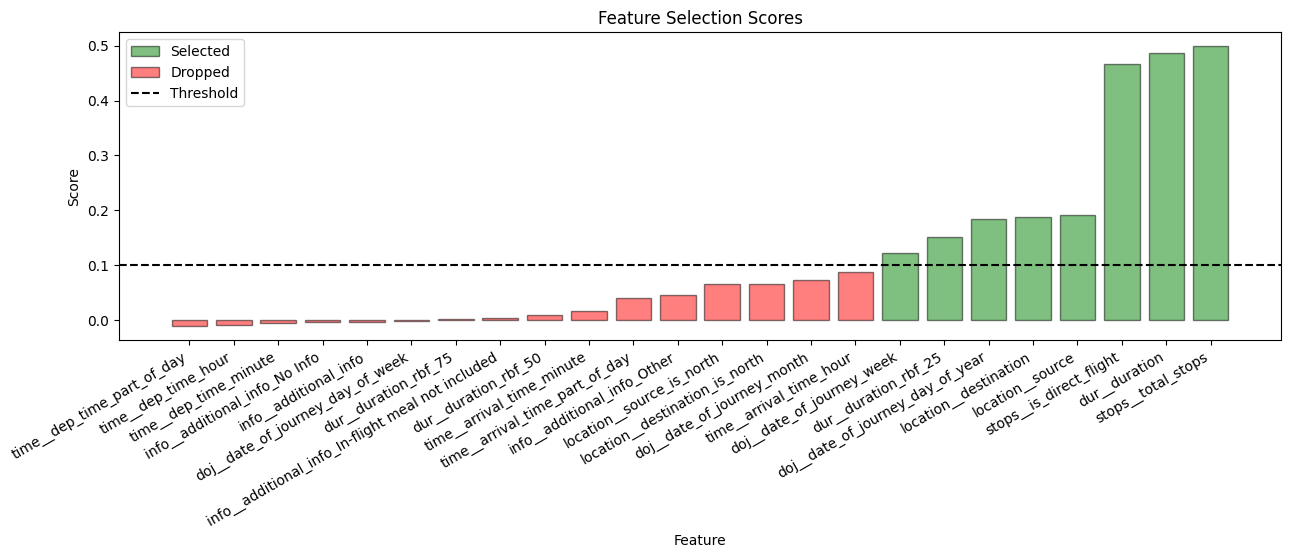

In [51]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()